# Install Torch

In [1]:
!pip uninstall -y pillow
!CC="cc -mavx2" pip install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
torchvision 0.2.1 requires pillow>=4.1.1, which is not installed.
scikit-image 0.13.1 requires pillow>=2.1.0, which is not installed.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [2]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision
print(torchvision.get_image_backend())

PIL


In [3]:
!pip install tqdm

# Imports

In [0]:
import torch
import os
import sys
import logging
import io
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

In [0]:
%matplotlib inline

# Parameters

In [0]:
base_dir = '/content/fashion'
data_dir = base_dir + os.sep + 'data'
input_dir = data_dir + os.sep + 'input'
output_dir = data_dir + os.sep + 'output'
train_zip = input_dir + os.sep + 'train_data.zip'
val_zip = input_dir + os.sep + 'validation_data.zip'
train_dir = input_dir + os.sep + 'train_data'
val_dir = input_dir + os.sep + 'validation_data'
train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
train_labels_json = input_dir + os.sep + 'train.json'
val_labels_json = input_dir + os.sep + 'validation.json'
test_labels_json = input_dir + os.sep + 'test.json'
num_labels = 228

In [7]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7003
True
Tesla K80


In [0]:
os.makedirs(base_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Download Dataset

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import json

def md5_hash(fname, blocksize=4096):
    """ compute md5hash of a file """
    import hashlib
    hash = ''
    if not os.path.exists(fname):
        errmsg = "File %s does not exist" % (fname)
        print(errmsg)
        return ''
    try:
        hasher = hashlib.md5()
        with open(fname, 'rb') as f:
            buf = f.read(blocksize)
            while len(buf) > 0:
                hasher.update(buf)
                buf = f.read(blocksize)
        hash = hasher.hexdigest()
    except:
        print("Exception in hashing file")
        raise
    return hash

def _download(drive_service, file_id, loc):
  request = drive_service.files().get_media(fileId=file_id)
  fh = io.FileIO(loc, mode='wb')
  downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
  prev_progress = 0
  done = False
  with tqdm(total=100) as pbar:
    while done is False:
      status, done = downloader.next_chunk()
      if status:
        # print("Download %d%%." % int(status.progress() * 100))
        pbar.update(int(100 *(status.progress() - prev_progress)))
        prev_progress = status.progress()
  print("Download Complete!")
  file_size = os.path.getsize(loc)
  print("Downloaded %d bytes" % (file_size))

def download(file_id, loc):
  """Downloads a file to local file system."""  
  drive_service = build('drive', 'v3')
  
  request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
  rh = io.BytesIO()
  downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
  done = False
  while not done:
    _, done = downloader_mdata.next_chunk()
  mdata = json.loads(rh.getvalue())
  found = False
  md5drive = ''
  fname = ''
  for x in mdata['files']:
    if x['id'] == file_id:
      found = True
      md5drive = x['md5Checksum']
      fname = x['originalFilename']
      break
  if not found:
    print("{:s} : not found on gdrive".format(file_id))
  else:
    if os.path.exists(loc):
      if md5drive == md5_hash(loc):
        print("{:s} : file already present on colab".format(loc))
      else:
        print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
        _download(drive_service, file_id, loc)
    else:
      print("{:s} not present on colab ... downloading ...".format(loc))
      _download(drive_service, file_id, loc)
        


In [11]:
download(train_id, train_zip)
download(val_id, val_zip)
download(train_labels_id, train_labels_json)
download(val_labels_id, val_labels_json)
download(test_labels_id, test_labels_json)

/content/fashion/data/input/train_data.zip : file already present on colab
/content/fashion/data/input/validation_data.zip : file already present on colab
/content/fashion/data/input/train.json : file already present on colab
/content/fashion/data/input/validation.json : file already present on colab
/content/fashion/data/input/test.json : file already present on colab


In [0]:
import shutil
shutil.unpack_archive(train_zip, input_dir)
shutil.unpack_archive(val_zip, input_dir)


In [13]:
!ls -ltr /content/fashion/data/input

total 1628816
-rw-r--r-- 1 root root 623133900 May 21 06:57 train_data.zip
-rw-r--r-- 1 root root 649513008 May 21 07:01 validation_data.zip
-rw-r--r-- 1 root root 384707800 May 21 07:04 train.json
-rw-r--r-- 1 root root   4222518 May 21 07:04 validation.json
-rw-r--r-- 1 root root   5785993 May 21 07:04 test.json
drwxr-xr-x 2 root root    258048 May 21 07:04 train_data
drwxr-xr-x 2 root root    258048 May 21 07:05 validation_data


In [14]:
!ls -ltr /content/fashion/data/input/train_data | head

total 636932
-rw-r--r-- 1 root root  61060 May 21 11:19 1.jpg
-rw-r--r-- 1 root root  61806 May 21 11:19 10.jpg
-rw-r--r-- 1 root root  97998 May 21 11:19 100.jpg
-rw-r--r-- 1 root root  42627 May 21 11:19 1000.jpg
-rw-r--r-- 1 root root  49370 May 21 11:19 1001.jpg
-rw-r--r-- 1 root root 105654 May 21 11:19 10000.jpg
-rw-r--r-- 1 root root  95681 May 21 11:19 1003.jpg
-rw-r--r-- 1 root root  24032 May 21 11:19 1002.jpg
-rw-r--r-- 1 root root  91518 May 21 11:19 1005.jpg
ls: write error: Broken pipe


In [15]:
!ls -ltr /content/fashion/data/input/validation_data | head

total 663036
-rw-r--r-- 1 root root  89139 May 21 11:19 1.jpg
-rw-r--r-- 1 root root  61895 May 21 11:19 10.jpg
-rw-r--r-- 1 root root  56745 May 21 11:19 100.jpg
-rw-r--r-- 1 root root  53685 May 21 11:19 1001.jpg
-rw-r--r-- 1 root root  55370 May 21 11:19 1000.jpg
-rw-r--r-- 1 root root  56689 May 21 11:19 1003.jpg
-rw-r--r-- 1 root root  81057 May 21 11:19 1002.jpg
-rw-r--r-- 1 root root  70008 May 21 11:19 1005.jpg
-rw-r--r-- 1 root root  38732 May 21 11:19 1004.jpg
ls: write error: Broken pipe


# Dataset

In [0]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = {}
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    labels[int(x['imageId'])] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.num_labels = num_labels
    self.images = {}
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.labelinfo = get_labelinfo(self.metadata['annotations'])
    self.labels = fetch_labels(self.metadata['annotations'], self.num_labels)

    for x in self.metadata['images']:
      self.images[int(x['imageId'])] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))  
    

  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.images[index], self.labels[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Target Transforms (if any): '
    fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [17]:
train_dset = FashionDataset(train_dir, train_labels_json, num_labels)
val_dset = FashionDataset(val_dir, val_labels_json, num_labels)


print(train_dset)
print(val_dset)

Dataset FashionDataset
    Number of datapoints: 1014544
    Number of labels: 228
    Root Location: /content/fashion/data/input/train_data
    Metadata file: /content/fashion/data/input/train.json
    Transforms (if any): None
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of labels: 225
    Root Location: /content/fashion/data/input/validation_data
    Metadata file: /content/fashion/data/input/validation.json
    Transforms (if any): None
    Target Transforms (if any): None
    Loader: default_loader


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


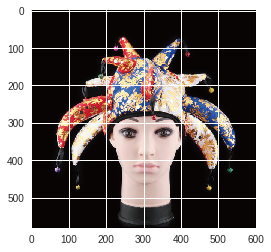

In [18]:
rnd1 = np.random.randint(len(train_dset)) % 1000   # TODO: remove truncation for reduced dataset
im1, lbl1 = train_dset[rnd1]
imshow(np.asarray(im1))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


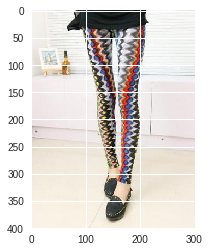

In [19]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(np.asarray(im2))
print(lbl2)

# DataLoader

# Model

# Loss Function


# Update Rule

# Training Loop


# Save Results